# Run the deconvolution and extract PSF photometry

This notebook demonstrates how the point source photometry of the "sparkles" can be measured. It requires the narrow PSFs estimated in the previosu notebook.

By [Martin Millon](https://martin-millon.gitlab.io), February 2023.

In [1]:
# Parameters (nbparametrise readable)
band = 'f200w'
mas = '40mas'

subsampling_factor = 2
epochs = 1 #number of epochs
noise_map_type = 'rms'
method_deconv = 'adabelief'
lambda_scales = 3
lambda_hf = 10
lambda_pts = 0.
lambda_positivity_bkg = 0
lambda_positivity_ps = 1000
regularize_pts_source = False 
update_lambda_pts_source = False

convolution_method = 'scipy'
from_ra_dec = False

In [2]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import json

from copy import deepcopy
from matplotlib import colors

from starred.deconvolution.deconvolution import setup_model
from starred.deconvolution.loss import Prior
from starred.deconvolution.parameters import ParametersDeconv
from starred.utils.generic_utils import Downsample, convert_numpy_array_to_list
from starred.procedures.deconvolution_routines import multi_steps_deconvolution
from starred.utils.ds9reg import export_astrometry_as_ds9region

from starred.plots import plot_function as pltf
from astropy.io import fits 
from astropy.wcs import WCS
from astropy import units as u
from astropy.coordinates import SkyCoord
import starred.plots.plot_function as pltf

import pandas as pd

#if running on CPU, might as well use double precision:
from jax.lib import xla_bridge
import jax 
if not (yourdevice := xla_bridge.get_backend().platform ) == 'gpu':
    jax.config.update("jax_enable_x64", True) #we require double digit precision
print(f"You are running on {yourdevice}.")

print(jax.__version__)

You are running on gpu.
0.4.8


In [3]:
#Path definition
data_path = os.path.join(band, 'science', mas)
psf_path = os.path.join(band, 'PSF_reconstruction', 'reconstruction_ada_subsampling_rms_posi_MC_3.00_3.00_%i'%subsampling_factor)
suf = ''
if regularize_pts_source: 
    if update_lambda_pts_source: 
        suf = '_autoregpts'
    else: 
        suf = '_regpts%2.2f'%lambda_pts
else: 
    lambda_pts = 0.
        
output_folder = os.path.join(band, 'deconvolution', 'deconv_lambda%2.2f_%2.2f_%s_sub%i%s'%(lambda_scales, lambda_hf, noise_map_type, subsampling_factor,suf))
os.makedirs(output_folder, exist_ok=1)

### Retrieving data

In [4]:
file_paths = sorted(glob.glob(os.path.join(data_path, 'sparkler.fits')))
data = np.array([fits.open(f)[0].data for f in file_paths], dtype=float)
header = fits.open(file_paths[0])[0].header
wcs = WCS(header=header)

im_size = np.shape(data)[1]
im_size_up = im_size * subsampling_factor
print('Data shape:', data.shape)

# PSF reshaping
file_paths_psf= sorted(glob.glob(os.path.join(psf_path, 'narrow_PSF.fits')))
s = np.array([fits.open(f)[0].data for f in file_paths_psf])
s = s.reshape(epochs, s.shape[-1], s.shape[-1])
estimated_full_psf = fits.open(os.path.join(psf_path, 'full_PSF.fits'))[0].data

print('Narrow PSF shape:', s.shape)


# Retrieving the full PSF 
file_paths = sorted(glob.glob(os.path.join(psf_path, 'full_PSF.fits')))
if len(file_paths) == 0: 
    raise RuntimeError('Full PSF files not found')

fpsf = np.array([fits.open(f)[0].data for f in file_paths])
fpsf = fpsf.reshape(epochs, fpsf.shape[-1], fpsf.shape[-1])

print('Full PSF shape:', fpsf.shape)

# Noise map
if noise_map_type == 'empirical':
    sigma_2 = np.zeros((epochs, im_size, im_size))
    sigma_sky_2 = np.array([np.std(data[i,int(0.9*im_size):,int(0.9*im_size):]) for i in range(epochs)]) ** 2
    for i in range(epochs):
        sigma_2[i,:,:] = sigma_sky_2[i] + data[i,:,:].clip(min=0)
elif noise_map_type == 'iweight':
    file_path_noise = sorted(glob.glob(os.path.join(data_path, 'sparkler_iweight_map.fits')))
    sigma_2 = np.array([fits.open(f)[0].data**2 for f in file_path_noise])
elif noise_map_type == 'rms':
    file_path_noise = sorted(glob.glob(os.path.join(data_path, 'sparkler_rms_map.fits')))
    sigma_2 = np.array([fits.open(f)[0].data**2 for f in file_path_noise])

print('Noise maps shape:', sigma_2.shape)

#Renormalise your data and the noise maps by the max of the first image. Works better when using adabelief
norm = data[0].max() / 100.
data /= norm
sigma_2 /= norm**2

data = np.asarray(data)
sigma_2 = np.asarray(sigma_2)

#Check that there is no inf value in the noise maps:
for i in range(1):
    ind = np.where(sigma_2[i,:,:] == np.inf)
    for j,k in zip(ind[0], ind[1]): 
        sigma_2[i,j,k] = 10*np.mean(np.ma.masked_invalid(sigma_2[i,:,:]))

Data shape: (1, 120, 120)
Narrow PSF shape: (1, 128, 128)
Full PSF shape: (1, 128, 128)
Noise maps shape: (1, 120, 120)


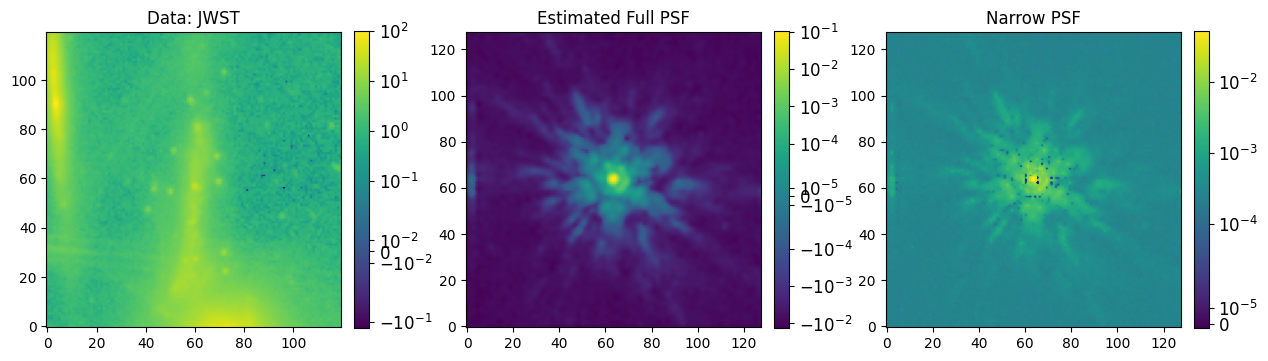

In [5]:
fig, axs = plt.subplots(1, 3, figsize=(15,15))
plt.subplots_adjust(wspace=0.3)
fraction = 0.046
pad = 0.04

plt.rc('font', size=12)           
axs[0].set_title('Data: JWST', fontsize=12)
axs[0].tick_params(axis='both', which='major', labelsize=10)
axs[2].set_title('Narrow PSF', fontsize=12)
axs[2].tick_params(axis='both', which='major', labelsize=10)
axs[1].set_title('Estimated Full PSF', fontsize=12)
axs[1].tick_params(axis='both', which='major', labelsize=10)

fig.colorbar(axs[0].imshow(data[0,:,:], norm=colors.SymLogNorm(linthresh=5e-2), origin='lower'), ax=axs[0], fraction=fraction, pad=pad)
fig.colorbar(axs[2].imshow(s[0,:,:], norm=colors.SymLogNorm(linthresh=5e-5), origin='lower'), ax=axs[1], fraction=fraction, pad=pad)
fig.colorbar(axs[1].imshow(estimated_full_psf, norm=colors.SymLogNorm(linthresh=5e-5), origin='lower'), ax=axs[2], fraction=fraction, pad=pad)
plt.show()

### Parameter initialization

In [6]:
if from_ra_dec: 
    df = pd.read_csv("table.txt", header=0, delimiter=' ')
    ra = df['RA'].values 
    dec= df['DEC'].values

    #add the previously undetected ones
    ra2 = np.asarray(['7:23:21.8496', '7:23:21.7752', '7:23:21.7843', '7:23:21.8573', '7:23:21.6591','7:23:21.7374','7:23:21.8201'])
    dec2 = ['-73:27:19.617', '-73:27:20.005','-73:27:20.284','-73:27:20.492','-73:27:20.194','-73:27:17.288','-73:27:20.057']

    ra_tot = np.concatenate((ra, ra2)) 
    dec_tot = np.concatenate((dec, dec2)) 

    #astrometry correction (CANUC team astrometry is sometime a bit off)
    pts_0 = ['07:23:21.86398752','-73:27:18.26372806']
    pts_1 = ['07:23:21.69999899','-73:27:18.36021867']
    pts_2 = ['07:23:21.69350474','-73:27:18.76924341']
    pts_6 = ['07:23:21.7857', '-73:27:19.413']
    pts_4 = ['07:23:21.9379', '-73:27:18.857']

    ra_tot[0], dec_tot[0] = pts_0
    ra_tot[1], dec_tot[1] = pts_1
    ra_tot[2], dec_tot[2] = pts_2
    ra_tot[6], dec_tot[6] = pts_6
    ra_tot[4], dec_tot[4] = pts_4

    c = SkyCoord(ra=ra_tot, dec=dec_tot, unit=(u.hourangle, u.deg))
    arr = np.array([c.ra, c.dec]).T  
    pix = wcs.wcs_world2pix(arr, 1)
    initial_c_x = np.array(pix[:,0]  - im_size/2.) 
    initial_c_y = np.array(pix[:,1]  - im_size/2.) 
else: 
    initial_c_x, initial_c_y = np.loadtxt("astrometry.txt") #use precomputed astrometry as an initial guess

print(initial_c_x, initial_c_y)

[ -8.02056207   9.4147694   10.17335074  -9.45710971 -16.10652134
 -18.59093356  -0.80648281  12.32988755  12.15139086  -1.2814697
   0.27028652   1.28386881  -7.49895251   0.72483702   0.16042539
  -7.62144335  12.81681147   5.12120942  -3.50434085] [ 11.65786246   9.34957297  -0.95314879  -5.04735848  -3.78123326
 -12.14563703 -17.23436104 -29.68225832  43.69047935  31.9719785
  -2.66479814  21.51335651 -22.33016144 -32.45619599 -38.95186015
 -44.3655175  -37.17579166  35.13273537 -33.15031705]


{'kwargs_analytic': {'alpha': array([0.]), 'dx': [0.0], 'dy': [0.0]}, 'kwargs_background': {}, 'kwargs_sersic': {}}


/home/users/millon/.local/lib/python3.9/site-packages/jax/_src/scipy/signal.py:78: UserWarning: convolve() ignores method argument
  warnings.warn("convolve() ignores method argument")


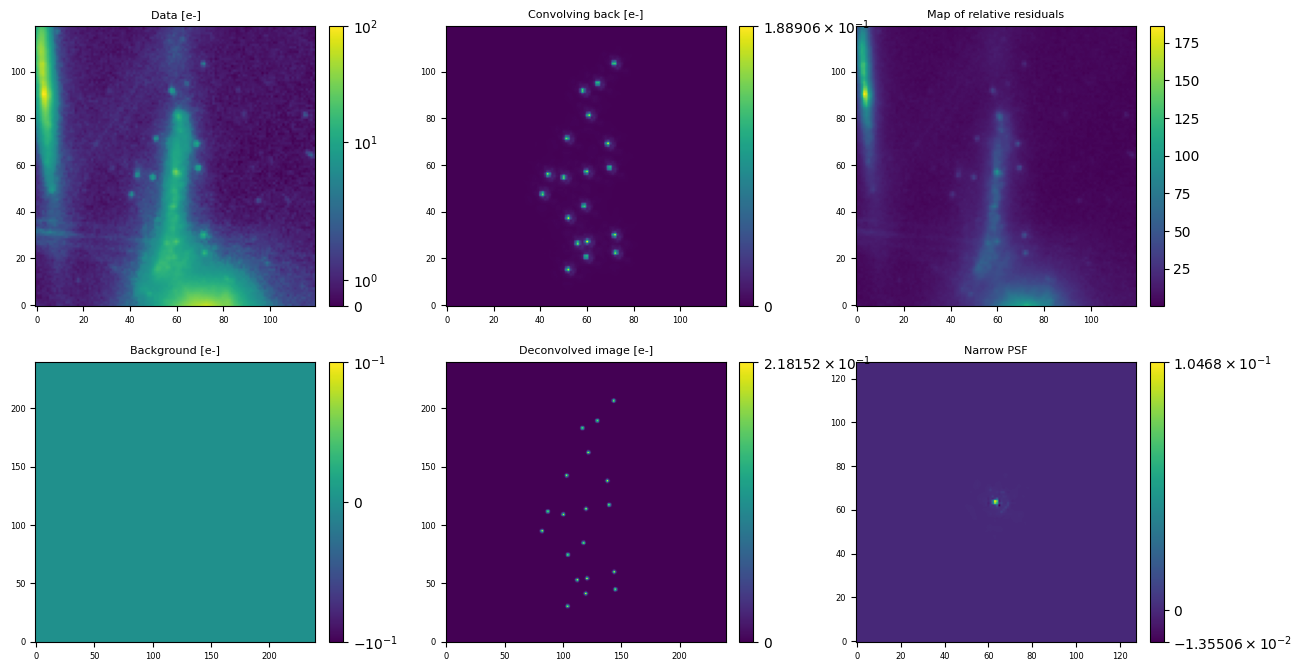

In [7]:

M = len(initial_c_x)
initial_a = np.ones(M) * 1.

model, kwargs_init, kwargs_up, kwargs_down, kwargs_fixed = setup_model(data, 
                                                                       sigma_2, 
                                                                       s, 
                                                                       initial_c_x,
                                                                       initial_c_y, 
                                                                       subsampling_factor,
                                                                       initial_a=initial_a,
                                                                       convolution_method=convolution_method)

print(kwargs_fixed)
parameters = ParametersDeconv(kwargs_init, 
                              kwargs_fixed, 
                              kwargs_up=kwargs_up, 
                              kwargs_down=kwargs_down)

#view intitial conditions 
cut_dict = {
            'linthresh':[5, 5, None, 5, 5, 5],
            'vmin':[0, 0, None, None, 0, None],
            'vmax':[None, None, None, None, None, None],
        }
fig_preview = pltf.plot_deconvolution(model, data, sigma_2, s, kwargs_init, epoch = 0, units='e-', cut_dict=cut_dict)
plt.show()

### Prepare the fitting sequence

In [8]:
fitting_sequence = [
                    ['pts-source-astrometry'], # we first fix the astrometry of the point source
                    [], # we then rerun the fit with all degrees of freedom
                    
        ]

optim_list = ['adabelief','adabelief']

kwargs_optax = {
        'max_iterations': 1000, 'min_iterations': None,
        'init_learning_rate': 5e-2, 'schedule_learning_rate': True,
        'restart_from_init': False, 'stop_at_loss_increase': False,
        'progress_bar': True, 'return_param_history': True
    }

kwargs_optax2 = {
        'max_iterations': 1500, 'min_iterations': None,
        'init_learning_rate': 1e-2, 'schedule_learning_rate': True,
        'restart_from_init': False, 'stop_at_loss_increase': False,
        'progress_bar': True, 'return_param_history': True
    }

kwargs_lbfgs = {'maxiter':1000}
kwargs_optim_list = [kwargs_optax, kwargs_optax2]

prior_astrom = Prior(prior_analytic=[['c_x',initial_c_x,3.], ['c_y',initial_c_y, 3.]], prior_background=None)
prior_list=[None,prior_astrom] #We place a wide Gaussian prior on the position of the point source (this is not necessary but avoid problems when point sources are not detected in certain bands)

### Run the fit

Step 1, fixing : ['pts-source-astrometry']


optax.adabelief: 100%|██████████| 1000/1000 [00:11<00:00, 83.51it/s]


Step 1/2 took 12 seconds
Kwargs partial at step 1/2 {'kwargs_analytic': {'a': Array([0.27298474, 0.4010207 , 0.5071896 , 0.34059945, 0.2237496 ,
       0.2639801 , 0.7056472 , 0.57130027, 0.2185129 , 0.38784367,
       1.3735535 , 0.41799653, 0.05419644, 0.63693064, 0.43610245,
       0.41606   , 0.5986536 , 0.11448444, 0.5053687 ], dtype=float32), 'c_x': Array([ -8.020562  ,   9.414769  ,  10.17335   ,  -9.457109  ,
       -16.106522  , -18.590933  ,  -0.8064828 ,  12.329887  ,
        12.151391  ,  -1.2814697 ,   0.27028653,   1.2838688 ,
        -7.4989524 ,   0.724837  ,   0.1604254 ,  -7.6214433 ,
        12.816812  ,   5.1212096 ,  -3.504341  ], dtype=float32), 'c_y': Array([ 11.657863 ,   9.349573 ,  -0.9531488,  -5.0473585,  -3.7812333,
       -12.145637 , -17.234362 , -29.682259 ,  43.69048  ,  31.97198  ,
        -2.6647983,  21.513357 , -22.330162 , -32.456196 , -38.95186  ,
       -44.365517 , -37.175793 ,  35.132736 , -33.15032  ], dtype=float32), 'dx': Array([0.], dtype=f

optax.adabelief: 100%|██████████| 1500/1500 [00:14<00:00, 104.94it/s]


Step 2/2 took 15 seconds
Kwargs partial at step 2/2 {'kwargs_analytic': {'a': Array([0.28119752, 0.4631312 , 0.51855236, 0.38153493, 0.2878442 ,
       0.25138053, 0.41843435, 0.60327137, 0.21574377, 0.37769186,
       1.1783489 , 0.26692843, 0.080688  , 0.48643655, 0.26879162,
       0.2048682 , 0.61899114, 0.13158892, 0.31873128], dtype=float32), 'c_x': Array([ -7.9499955 ,   9.339427  ,  10.221543  ,  -9.207195  ,
       -16.022318  , -18.628628  ,  -0.7476004 ,  12.238006  ,
        12.260849  ,  -1.1764169 ,   0.2692395 ,   1.24288   ,
        -7.2201667 ,   0.87462145,  -0.07106547,  -7.746708  ,
        12.910649  ,   5.238533  ,  -3.647171  ], dtype=float32), 'c_y': Array([ 11.739807 ,   9.116905 ,  -0.9879939,  -5.074493 ,  -4.0713596,
       -12.106072 , -17.514519 , -29.888775 ,  43.593155 ,  32.058773 ,
        -2.902238 ,  21.60648  , -22.888716 , -32.374634 , -39.068478 ,
       -44.190624 , -37.177376 ,  34.97158  , -33.09978  ], dtype=float32), 'dx': Array([0.], dtype=f

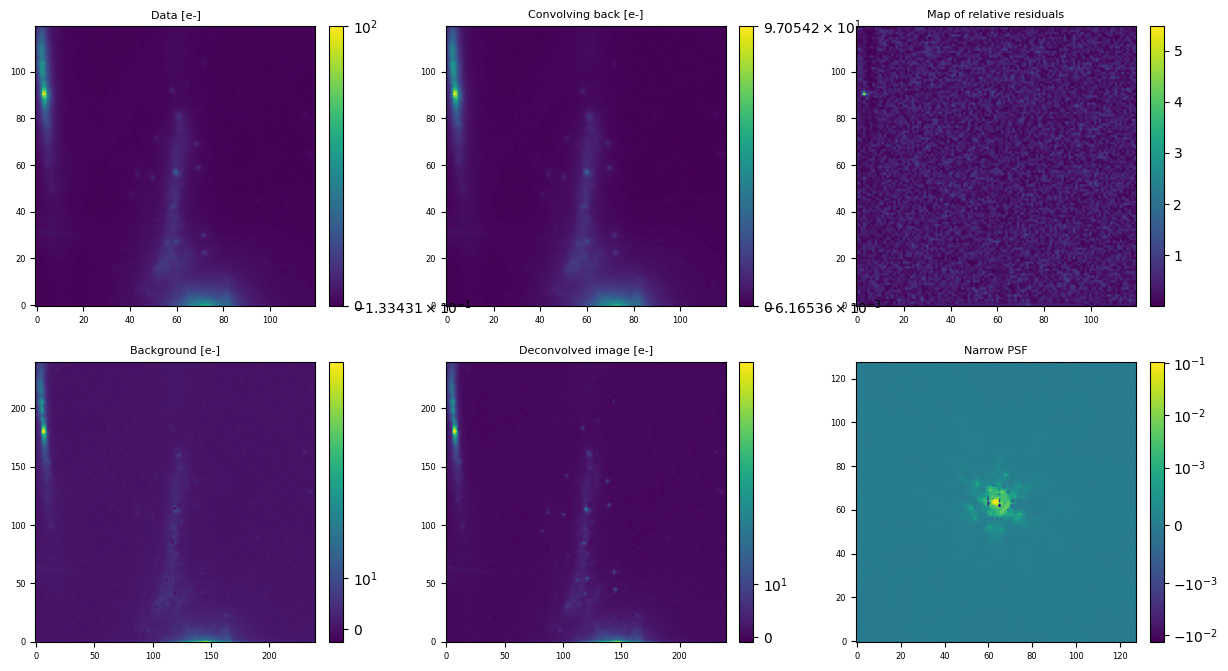

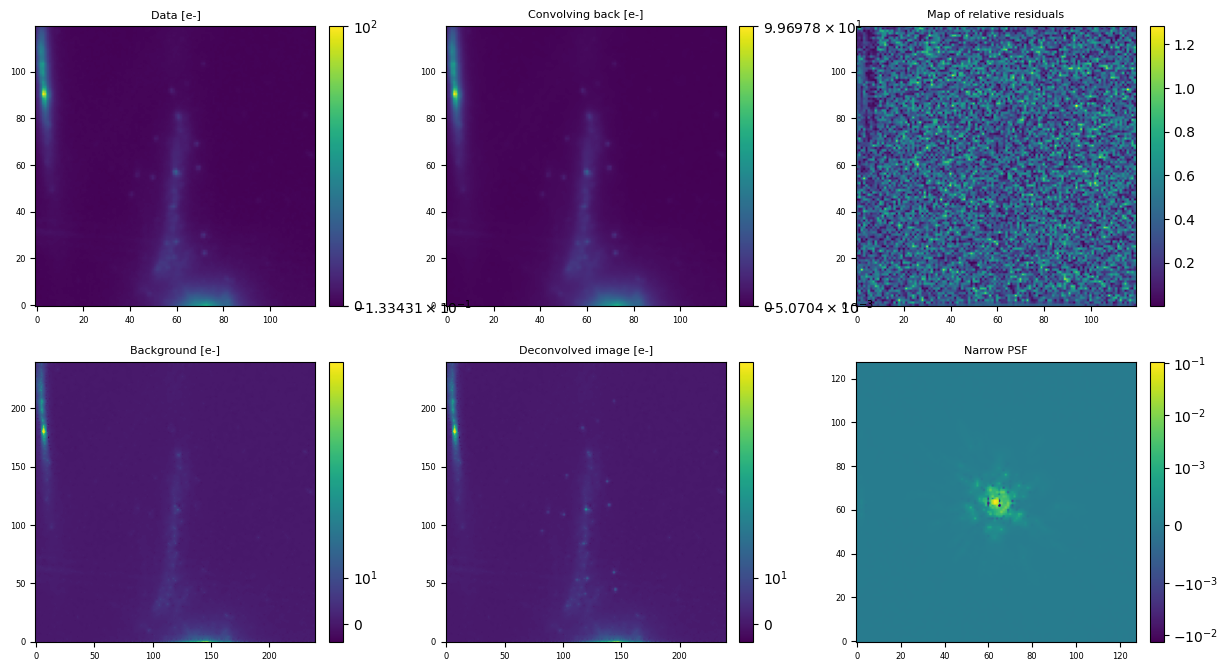

In [9]:
model, parameters, loss, kwargs_partial_list, fig_list, LogL_list, loss_history_list = multi_steps_deconvolution(data, model, parameters, sigma_2, s, subsampling_factor,
                                                                                    fitting_sequence = fitting_sequence,
                                                                                    optim_list = optim_list, kwargs_optim_list = kwargs_optim_list,
                                                                                    lambda_scales = lambda_scales, lambda_hf =lambda_hf, lambda_positivity_bkg = lambda_positivity_bkg, 
                                                                                    lambda_positivity_ps=lambda_positivity_ps, lambda_pts_source=lambda_pts,
                                                                                    prior_list = prior_list, regularize_full_model = False, adjust_sky = False,
                                                                                    noise_propagation = 'MC', update_lambda_pts_source=update_lambda_pts_source)

### Check the convergence and retrieve the final parameters

Step 1, optimiser adabelief
Step 2, optimiser adabelief


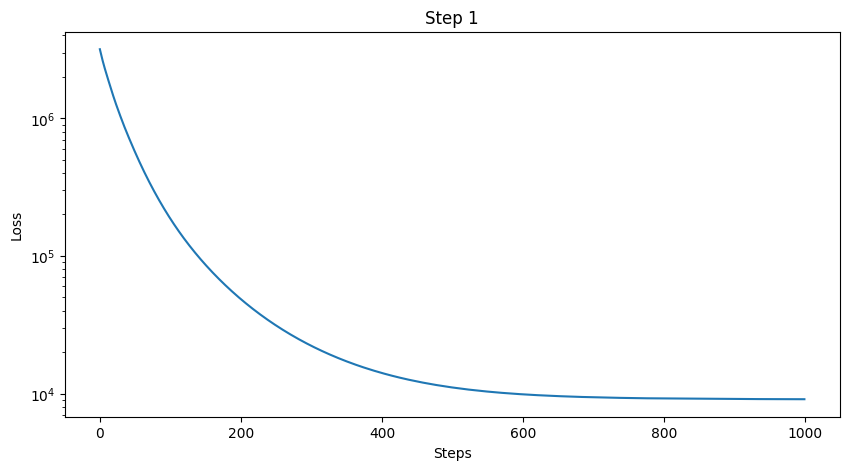

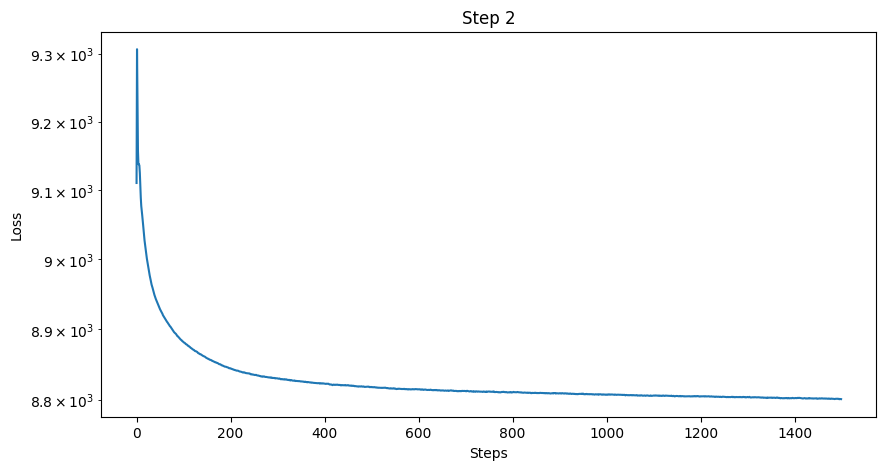

In [10]:
# Retrieving final results
kwargs_final = kwargs_partial_list[-1]
lambda_pts_source_new = deepcopy(loss._lambda_pts_source)
if lambda_pts_source_new != lambda_pts:
    print(f'Pts regularisation strenght has been changed from {lambda_pts} to {lambda_pts_source_new}')
    lpts2 = deepcopy(loss.update_lambda_pts_source(kwargs_final))
    print(f'New one would be {lpts2}')
else:
    lpts2 = lambda_pts
    
for i in range(len(loss_history_list)):
    print('Step %i, optimiser %s'%(i+1, optim_list[i]))
    figloss=pltf.plot_loss(loss_history=loss_history_list[i], title = 'Step %i'%(i+1))
    figloss.savefig(os.path.join(output_folder, 'fig_loss%i.png'%i))


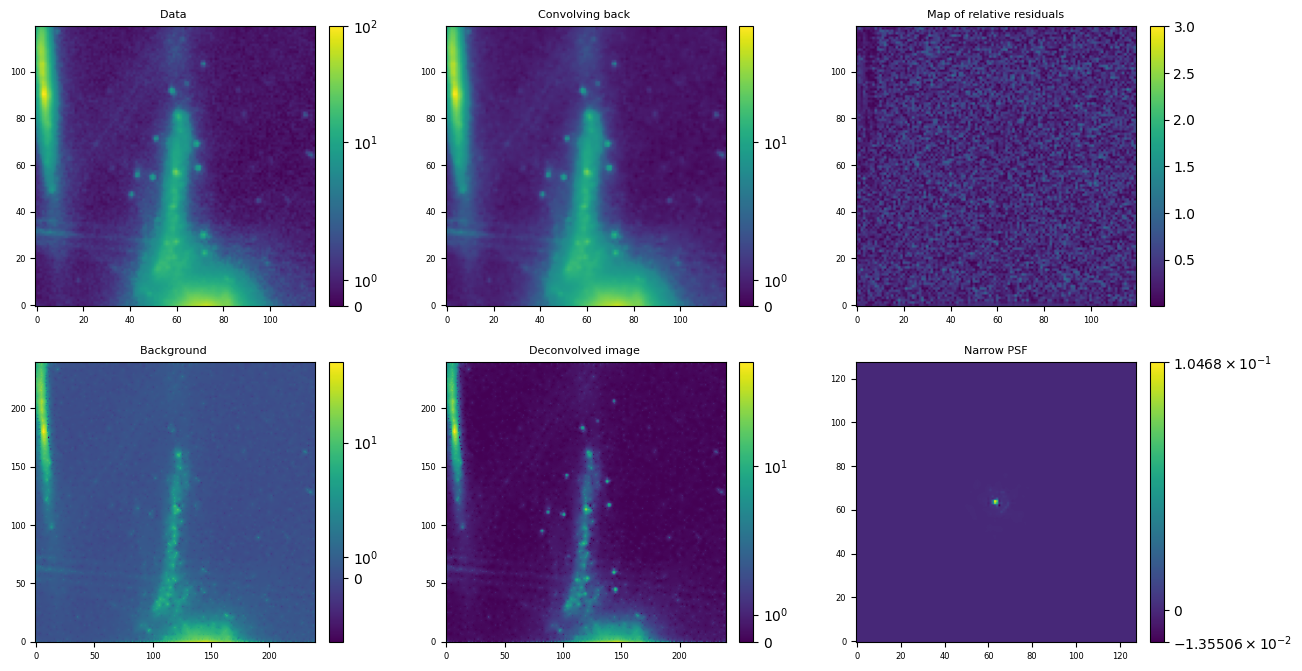

In [11]:
#view intitial conditions 
cut_dict = {
            'linthresh':[5, 5, None, 5, 5, 5],
            'vmin':[0, 0, None, -3, 0, None],
            'vmax':[None, None, 3, None, None, None],
        }
fig = pltf.plot_deconvolution(model, data, sigma_2, s, kwargs_final, epoch = 0, units=None, figsize=(15, 10), cut_dict=cut_dict)
fig.savefig(os.path.join(output_folder, 'summary_fig.pdf'))

### Check the final point source positions

/tmp/ipykernel_195236/1317256260.py:5: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(data[0,: ,: ] * norm), origin='lower')


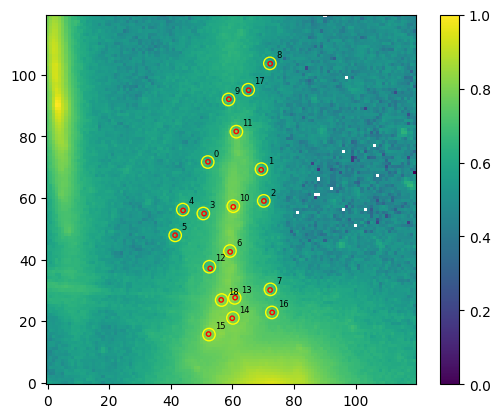

/tmp/ipykernel_195236/1317256260.py:16: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.nan_to_num(np.log10(deconv * norm)), origin='lower', vmin=0, vmax = 1.0)


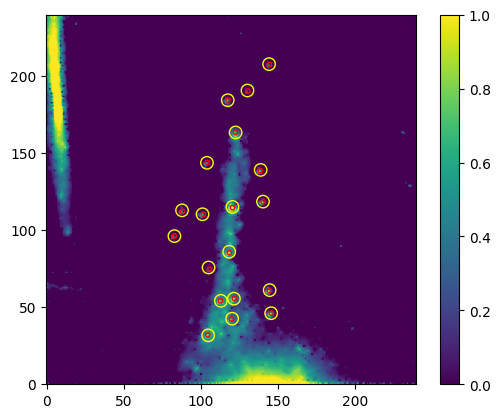

[ 0.07056665 -0.07534218  0.04819298  0.24991417  0.08420372 -0.03769493
  0.05888242 -0.09188175  0.10945797  0.10505283 -0.00104704 -0.0409888
  0.2787857   0.14978445 -0.23149087 -0.12526464  0.09383774  0.1173234
 -0.14283013]
[ 0.08194447 -0.23266792 -0.03484511 -0.02713442 -0.29012632  0.03956413
 -0.2801571  -0.20651627 -0.09732437  0.0867939  -0.23743963  0.09312248
 -0.5585537   0.08156204 -0.11661911  0.17489243 -0.0015831  -0.1611557
  0.05053711]
[104.100006 138.67885  140.44308  101.58561   87.95537   82.742744
 118.5048   144.47601  144.5217   117.64716  120.53848  122.48576
 105.55967  121.749245 119.85787  104.506584 145.8213   130.47707
 112.70566 ]
[143.47961  138.23381  118.02401  109.85101  111.857285  95.78786
  84.97096   60.22245  207.18631  184.11755  114.195526 163.21295
  74.222565  55.250732  41.863045  31.618752  45.64525  189.94316
  53.800438]


In [12]:
final_cx = kwargs_final['kwargs_analytic']['c_x'] 
final_cy = kwargs_final['kwargs_analytic']['c_y']

plt.figure()
plt.imshow(np.log10(data[0,: ,: ] * norm), origin='lower')
plt.scatter(final_cx + im_size/2., final_cy + im_size/2., s= 10, facecolors='none', edgecolors='r')
plt.scatter(initial_c_x + im_size/2. , initial_c_y + im_size/2., s= 80, marker='o', facecolors='none', edgecolors='yellow')
for i in range(M):
    plt.text(initial_c_x[i] + im_size/2. +2 , initial_c_y[i]+ im_size/2.+2, str(i), fontsize=6)
plt.colorbar()
plt.savefig(os.path.join(output_folder, 'pts_source_position.png'))
plt.show()

deconv, back = model.getDeconvolved(kwargs_final, 0) 
plt.figure()
plt.imshow(np.nan_to_num(np.log10(deconv * norm)), origin='lower', vmin=0, vmax = 1.0)
plt.scatter((final_cx + im_size/2.)*subsampling_factor, (final_cy + im_size/2.)*subsampling_factor, s= 10, facecolors='none', edgecolors='r')
plt.scatter((initial_c_x + im_size/2.)*subsampling_factor , (initial_c_y + im_size/2.)*subsampling_factor, s= 80, marker='o', facecolors='none', edgecolors='yellow')
plt.colorbar()
plt.savefig(os.path.join(output_folder, 'pts_source_position_dec.png'))
plt.show()


print(final_cx - initial_c_x )
print(final_cy - initial_c_y )

print((final_cx + im_size/2.)*subsampling_factor )
print((final_cy + im_size/2.)*subsampling_factor )

#export as region 
radec_out= wcs.pixel_to_world(final_cx + im_size/2. - 2 + 1./subsampling_factor, final_cy + im_size/2. - 2 + 1./subsampling_factor) # -1 to match ds9 indexing + correction for subpixel grid indexing 
radec_in = wcs.pixel_to_world(initial_c_x + im_size/2.- 1, initial_c_y + im_size/2.- 1)

export_astrometry_as_ds9region(model, output_folder, kwargs_final, header, regsize=0.02)

### Check the chi2

In [13]:
chi2 =  -2 * loss._log_likelihood_chi2(kwargs_final) / (im_size ** 2)
Logl_regul =  loss._log_regul(kwargs_final)
Logl =  loss._log_likelihood(kwargs_final)
inv_loss = - loss.loss(parameters.kwargs2args(kwargs_final))

print('chi2 :', chi2)
print('Logl :', Logl)
print('Logl regul:', Logl_regul)
print('-Loss:', inv_loss )

info_dic =  {'chi2': float(chi2), 'Logl':float(Logl), 'Logl regul':float(Logl_regul), 'Inverse Loss':float(inv_loss), 'Norm':float(norm),
             'lambda_scales':float(lambda_scales), 'lambda_hf':float(lambda_hf), 'lambda_pts_source':float(lambda_pts_source_new), 'lambda_pts_source_next':float(lpts2)}

with open(os.path.join(output_folder, 'info_dic.json'), 'w') as f: 
    json.dump(info_dic, f)

chi2 : 0.1923385
Logl : -1384.8372
Logl regul: -7416.791
-Loss: -8801.6875


### Compute photometric errors 
We use a simple approximation for PSF photometry uncertainties from 
https://www.stsci.edu/files/live/sites/www/files/home/hst/documentation/_documents/wfpc2/wfpc2_ihb_cycle17.pdf
(Heyer, Biretta, et al. 2004, WFPC2 Instrument Handbook, Version 10.0, Chapter 6)

This does not account for the covariance between the background and the point sources, but it still gives a reasonable estimate. The proper way to do that would be to sample the model parameters in a Hamiltonian Monte-Carlo to capture all covariances, but this is too expensive computationally for this test. 

In [15]:
photometry = model.flux_at_epoch(kwargs_final) * norm 
print(photometry) #photometry is already in nJy

df = pd.read_csv("table.txt", header=0, delimiter=' ')
print(df[f"{band}_flux_nJy"])

#save photometry as astrometry in a text file
photom_key = f'{band}_flux_nJy'
photom_key_error = f'{band}_flux_nJy_errWPC'
dic = {'RA':[], 'DEC':[], photom_key:[], 'x_pos':[], 'y_pos':[], 'x_pos_init':[], 'y_pos_init':[]}

for i in range(M):
    stri = radec_out.to_string('hmsdms', sep=':')[i].split(' ')
    dic['RA'].append(stri[0])
    dic['DEC'].append(stri[1])
    dic[photom_key].append(np.float64(photometry[i]))
    dic['x_pos'].append(np.float64(final_cx[i]))
    dic['y_pos'].append(np.float64(final_cy[i]))
    dic['x_pos_init'].append(np.float64(initial_c_x[i]))
    dic['y_pos_init'].append(np.float64(initial_c_y[i]))

#Compute the errors (WPC PSF photometry estimate)
fpsf_lr = Downsample(fpsf[0, :, :], factor = subsampling_factor)
fpsf_lr /= np.sum(fpsf_lr)
sigma_WPFC_lr = np.zeros(M)
sharpness_lr = np.sum(fpsf_lr * fpsf_lr)
empty = fits.open(os.path.join(data_path, 'empty.fits'))[0].data
bkg_sigma2 = np.std(empty)**2

flux = model.flux_at_epoch(kwargs_final, epoch=0) * norm
for j in range(M): 
    sigma_WPFC_lr[j] = np.sqrt(flux[j] + bkg_sigma2/sharpness_lr)

dic[photom_key_error] = sigma_WPFC_lr.tolist()

[22.607576  37.23459   41.69031   30.674454  23.141954  20.210367
 33.641075  48.50151   17.345259  30.365482  94.736305  21.460379
  6.4871135 39.10828   21.610174  16.470892  49.76534   10.57942
 25.625196 ]
0      41.051183
1      72.037726
2      41.529155
3      35.972879
4      44.431831
5      32.122011
6      82.666132
7      91.617503
8      22.364202
9      60.529235
10    328.855384
11    271.684172
Name: f200w_flux_nJy, dtype: float64


### Save the results

In [16]:
with open(os.path.join(output_folder, 'photom.json'), 'w') as f: 
    json.dump(dic, f)

In [17]:
model.export(output_folder, kwargs_final, data, sigma_2, format='fits', header = header, norm=norm)

with open(os.path.join(output_folder, 'kwargs_final.json'), 'w') as f: 
    json.dump(convert_numpy_array_to_list(kwargs_final), f)

Exporting all epochs


In [18]:
np.savetxt(os.path.join(output_folder, 'astrometry.txt'), [kwargs_final['kwargs_analytic']['c_x'], kwargs_final['kwargs_analytic']['c_y']])